<a href="https://colab.research.google.com/github/KimJisanER/Practice_med_pha/blob/main/labeling_reaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit
!pip install molvs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for molvs: filename=MolVS-0.1.1-py3-none-any.whl size=32373 sha256=6142665c9d7a740097fcb7254971c4855aaa1fda979b2cf7831eab194cc660c4
  Stored in directory: /root/.cache/pip/wheels/24/a1/39/f02f8173c8ed91bdd386a6c608bb6bf8bd0aba7119315d6f6f
Successfully built molvs


In [2]:
import numpy as np
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from molvs import Standardizer
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import rdFMCS

In [3]:
reaction_rules = pd.read_csv('/content/drive/MyDrive/reaction_rules.csv')

In [4]:
reaction_rules

,Name,SMIRKS Strings,Common Type
0,Hydroxylation,[*:1][H]>>[H][#8]-[*:1],Hydroxylation
1,Oxidation,[*:1]>>O=[*:1],Oxidation
2,N-Oxidation Nitric Oxide formation,[#7:1]>>[#7:1]=O,N-Oxidation
3,N-Oxidation with charge,[#7:1]>>[#7+:1]-[#8-],N-Oxidation
4,C Oxidation,[H][#8:2][#6;A:1]>>[#6;A:1]=[O:2],Oxidation
5,O-Dealkylation,[H][#6:2][#8;A:1]>>[#8;A:1][H].[#6:2]=O,Cleavage
6,N-Dealkyaltion,[H][#6;A:2][#7;A:1]>>[#7;A:1][H].[#6;A:2]=O,Cleavage
7,S-Dealkyaltion,[H][#6;A:2][#16;A:1]>>[#16;A:1][H].[#6;A:2]=O,Cleavage
8,EpOxidation,[*:1]=[*:2]>>[#8]-1-[*:1]-[*:2]-1,Epoxidation
9,Nitrogen dioxide reduction,[#8;A:3][#7;A+:1]=[#8;A:2]>>[#7;A:1].[#8:2].[#...,Reduction


In [44]:
def sanitize_smiles_molvs(smiles, largest_fragment=False):

    standardizer = Standardizer()
    standardizer.prefer_organic = True

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return smiles
    try:
        mol = standardizer.standardize(mol)  # standardize functional group reps
        if largest_fragment:
            mol = standardizer.largest_fragment(mol) # remove product counterions/salts/etc.
        mol = standardizer.uncharge(mol)  # neutralize, e.g., carboxylic acids
    except Exception:
        pass
    return Chem.MolToSmiles(mol)

def count_O(mol):
    o_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'O')
    return o_count

def convert_to_reaction_smiles(substrate, metabolite):
    mcs = rdFMCS.FindMCS([substrate, metabolite])
    patt = Chem.MolFromSmarts(mcs.smartsString)

    metabolite_match = list(metabolite.GetSubstructMatch(patt))
    substrate_match = list(substrate.GetSubstructMatch(patt))

    index_dict = {}
    for i, j in zip(metabolite_match, substrate_match):
        index_dict[i] = j

    for atom in substrate.GetAtoms():
        atom.SetProp('molAtomMapNumber', str(atom.GetIdx()+1))

    heavy_atom_count = metabolite.GetNumHeavyAtoms()
    map_number_residue = [idx for idx in range(heavy_atom_count) if idx not in substrate_match]

    count = 0
    O_mapnumber_list =[]

    for atom in metabolite.GetAtoms():
        if atom.GetIdx() in metabolite_match:
            atom.SetProp('molAtomMapNumber', str(index_dict[atom.GetIdx()]+1))
        else:
            atom.SetProp('molAtomMapNumber', str(map_number_residue[count]+1))
            if atom.GetSymbol() == 'O':
                O_mapnumber_list.append(map_number_residue[count]+1)
            count += 1

    reactant_smiles = Chem.MolToSmiles(substrate)
    product_smiles = Chem.MolToSmiles(metabolite)

    H20_count = count_O(metabolite)- count_O(substrate)

    for H20 in range(H20_count):
        O_map_number = O_mapnumber_list[H20]
        reactant_smiles += f".[OH2:{O_map_number}]"

    reaction = AllChem.ReactionFromSmarts(f"{reactant_smiles}>>{product_smiles}")

    return reaction

In [188]:
sm1 ="""
Mrv0541 04191212152D

 19 20  0  0  1  0            999 V2000
   16.8537   -6.8636    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   16.8537   -6.0579    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   16.1375   -7.2933    0.0000 S   0  0  0  0  0  0  0  0  0  0  0  0
   17.6415   -7.1322    0.0000 S   0  0  0  0  0  0  0  0  0  0  0  0
   16.1375   -5.6460    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   17.6415   -5.7893    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   15.4213   -6.8636    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   15.7257   -7.9916    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   16.5135   -7.9916    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   18.1071   -6.4697    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   15.4213   -6.0579    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   16.1375   -4.8045    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   14.7230   -7.2933    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   18.9307   -6.4697    0.0000 S   0  0  0  0  0  0  0  0  0  0  0  0
   19.3425   -7.1859    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   18.9307   -5.6460    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   19.6469   -6.0758    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   15.4182   -4.3995    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   14.7072   -4.8202    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  2  1  2  0  0  0  0
  3  1  1  0  0  0  0
  4  1  1  0  0  0  0
  5  2  1  0  0  0  0
  6  2  1  0  0  0  0
  7  3  1  0  0  0  0
  8  3  2  0  0  0  0
  9  3  2  0  0  0  0
 10  4  1  0  0  0  0
 11  5  1  0  0  0  0
  5 12  1  6  0  0  0
 10  6  2  0  0  0  0
  7 13  1  1  0  0  0
 11  7  1  0  0  0  0
 14 10  1  0  0  0  0
 15 14  1  0  0  0  0
 16 14  2  0  0  0  0
 17 14  2  0  0  0  0
 12 18  1  0  0  0  0
 18 19  1  0  0  0  0
M  END
> <DATABASE_ID>
DB00869

> <DATABASE_NAME>
drugbank

> <SMILES>
CCN[C@H]1C[C@H](C)S(=O)(=O)C2=C1C=C(S2)S(N)(=O)=O

> <INCHI_IDENTIFIER>
InChI=1S/C10H16N2O4S3/c1-3-12-8-4-6(2)18(13,14)10-7(8)5-9(17-10)19(11,15)16/h5-6,8,12H,3-4H2,1-2H3,(H2,11,15,16)/t6-,8-/m0/s1

> <INCHI_KEY>
IAVUPMFITXYVAF-XPUUQOCRSA-N

> <FORMULA>
C10H16N2O4S3

> <MOLECULAR_WEIGHT>
324.44

> <EXACT_MASS>
324.02721908

> <JCHEM_ACCEPTOR_COUNT>
5

> <JCHEM_ATOM_COUNT>
35

> <JCHEM_AVERAGE_NEUTRAL_MICROSPECIES_CHARGE>
0.35984872112422067

> <JCHEM_AVERAGE_POLARIZABILITY>
31.554520288675878

> <JCHEM_BIOAVAILABILITY>
1

> <JCHEM_DONOR_COUNT>
2

> <JCHEM_FORMAL_CHARGE>
0

> <JCHEM_GHOSE_FILTER>
1

> <JCHEM_IUPAC>
(2S,4S)-4-(ethylamino)-2-methyl-1,1-dioxo-2H,3H,4H-1lambda6-thieno[2,3-b]thiopyran-6-sulfonamide

> <ALOGPS_LOGP>
-0.50

> <JCHEM_LOGP>
-0.12213324118635148

> <ALOGPS_LOGS>
-2.67

> <JCHEM_MDDR_LIKE_RULE>
0

> <JCHEM_NEUTRAL_CHARGE>
1

> <JCHEM_NUMBER_OF_RINGS>
2

> <JCHEM_PHYSIOLOGICAL_CHARGE>
0

> <JCHEM_PKA>
15.782180963422169

> <JCHEM_PKA_STRONGEST_ACIDIC>
8.159008300686995

> <JCHEM_PKA_STRONGEST_BASIC>
6.875389580932636

> <JCHEM_POLAR_SURFACE_AREA>
106.32999999999998

> <JCHEM_REFRACTIVITY>
72.46110000000002

> <JCHEM_ROTATABLE_BOND_COUNT>
3

> <JCHEM_RULE_OF_FIVE>
1

> <ALOGPS_SOLUBILITY>
6.99e-01 g/l

> <JCHEM_TRADITIONAL_IUPAC>
tetrahydrofolic acid

> <JCHEM_VEBER_RULE>
0

> <DRUGBANK_ID>
DB00869

> <SECONDARY_ACCESSION_NUMBERS>
APRD00577; DB04507

> <DRUG_GROUPS>
approved

> <GENERIC_NAME>
Dorzolamide

> <SYNONYMS>
(4S,6S)-4-ethylamino-6-methyl-7,7-dioxo-4,5,6,7-tetrahydro-7lambda*6*-thieno[2,3-b]thiopyran-2-sulfonic acid amide; (4S,trans)-4-(ethylamino)-6-methyl-5,6-dihydro-4H-thieno[2,3-b]thiopyran-2-sulfonamide 7,7-dioxide; 4-Ethylamino-6-methyl-7,7-dioxo-4,5,6,7-tetrahydro-7lambda*6*-thieno[2,3-b]thiopyran-2-sulfonic acid amide; 4-ethylamino-6-methyl-7,7-dioxo-4,5,6,7-tetrahydro-7lambda6-thieno[2,3-b]thiopyran-2-sulfonic acid amide; 4S,6S-dorzolamide; Dorzolamid; Dorzolamida; Dorzolamide; Dorzolamidum

> <PRODUCTS>
Act Dorzotimolol; Ag-dorzolamide Timolol; Apo-dorzo-timop; Apo-dorzolamide; Brim-Dor PF; Cosopt; Cosopt PF; Cosopt Preservative-free; DORZOLAMIDE HYDROCHLORIDE and TIMOLOL MALEATE; Dorzolamide; Dorzolamide Eye Drops BP; Dorzolamide HCl; Dorzolamide HCl /Timolol Maleate; Dorzolamide HCl and Timolol Maleate; Dorzolamide Hydrochloride; Dorzolamide Hydrochloride Ophthalmic; Dorzolamide Hydrochloride Ophthalmic Solution; Dorzolamide Hydrochloride Ophthalmic Solution 2%, 10mL Ophthalmic Solution 2%, 10mL; Dorzolamide Hydrochloride Timolol Maleate; Dorzolamide Hydrochloride Timolol Maletae; Dorzolamide Hydrochloride and Timolol Maleate; Dorzolamide Hydrochloride and Timolol Maleate Ophthalmic Solution; Dorzolamide Hydrochloride and Timolol Maleate Preservative Free; Dorzolamide Hydrochloride and Timolol Maleate ophthalmic; Dorzolamide Hydrochloride and Timolol Maleate ophthalmic Solution; Dorzolamide Hydrochloride-Timolol Maleate; Dorzolamide Hydrochloride-Timolol Maleate Ophthalmic Solution Sterile Ophthalmic Solution; Dorzolamide Hydrochloride-timolol Maleate; Dorzolamide PF; Dorzolamide and Timolol; Dorzolamide and Timolol Eye Drops BP; Dorzolamide hydrochloride; Dorzolamide hydrochloride and timolol maleate; Dorzolamide-timolol; Dorzolamide-timolol PF; Duokopt; Jamp Dorzolamide-timolol; Jamp-dorzolamide; M-dorzolamide-timolol; Med-dorzolamide; Med-dorzolamide-timolol; Mint-dorzolamide/timolol; Mylan-dorzolamide/timolol; PMS-dorzolamide-timolol; Priva-dorzolamide-timolol; Riva-dorzolamide; Riva-dorzolamide/timolol; Sandoz Dorzolamide; Sandoz Dorzolamide/timolol; Teva-dorzotimol; Tim-Brim-Dor PF; Tim-Brim-Dor-Lat; Tim-Dor PF; Tim-Dor-Lat; Trusopt; Trusopt Preservative-free; Van-dorzolamide-timolol

> <SALTS>
Dorzolamide hydrochloride
"""

sm2 = """
Mrv1909 02072021592D

 17 18  0  0  1  0            999 V2000
   16.4632   -6.7233    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   16.4632   -5.9171    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   15.7465   -7.1532    0.0000 S   0  0  0  0  0  0  0  0  0  0  0  0
   17.2516   -6.9921    0.0000 S   0  0  0  0  0  0  0  0  0  0  0  0
   15.7465   -5.5048    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   17.2516   -5.6482    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   15.0298   -6.7233    0.0000 C   0  0  2  0  0  0  0  0  0  0  0  0
   15.3345   -7.8521    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   16.1228   -7.8521    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   17.7175   -6.3291    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   15.0298   -5.9171    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   15.7465   -4.6627    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   14.3311   -7.1532    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   18.5417   -6.3291    0.0000 S   0  0  0  0  0  0  0  0  0  0  0  0
   18.9537   -7.0458    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   18.5417   -5.5048    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   19.2584   -5.9349    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
  2  1  2  0  0  0  0
  3  1  1  0  0  0  0
  4  1  1  0  0  0  0
  5  2  1  0  0  0  0
  6  2  1  0  0  0  0
  7  3  1  0  0  0  0
  8  3  2  0  0  0  0
  9  3  2  0  0  0  0
 10  4  1  0  0  0  0
 11  5  1  0  0  0  0
  5 12  1  6  0  0  0
 10  6  2  0  0  0  0
  7 13  1  1  0  0  0
 11  7  1  0  0  0  0
 14 10  1  0  0  0  0
 15 14  1  0  0  0  0
 16 14  2  0  0  0  0
 17 14  2  0  0  0  0
M  END
> <DATABASE_ID>
DBMET03010

> <DATABASE_NAME>
drugbank

> <SMILES>
C[C@H]1C[C@H](N)C2=C(SC(=C2)S(N)(=O)=O)S1(=O)=O

> <INCHI_IDENTIFIER>
InChI=1S/C8H12N2O4S3/c1-4-2-6(9)5-3-7(17(10,13)14)15-8(5)16(4,11)12/h3-4,6H,2,9H2,1H3,(H2,10,13,14)/t4-,6-/m0/s1

> <INCHI_KEY>
HVURBRAECUMAHY-NJGYIYPDSA-N

> <FORMULA>
C8H12N2O4S3

> <MOLECULAR_WEIGHT>
296.387

> <EXACT_MASS>
295.995918952

> <JCHEM_ACCEPTOR_COUNT>
5

> <JCHEM_ATOM_COUNT>
29

> <JCHEM_AVERAGE_NEUTRAL_MICROSPECIES_CHARGE>
0.5828236563068496

> <JCHEM_AVERAGE_POLARIZABILITY>
27.367445380245346

> <JCHEM_BIOAVAILABILITY>
1

> <JCHEM_DONOR_COUNT>
2

> <JCHEM_FORMAL_CHARGE>
0

> <JCHEM_GHOSE_FILTER>
0

> <JCHEM_IUPAC>
(2S,4S)-4-amino-2-methyl-1,1-dioxo-2H,3H,4H-1lambda6-thieno[2,3-b]thiopyran-6-sulfonamide

> <ALOGPS_LOGP>
-0.47

> <JCHEM_LOGP>
-0.9641184403872518

> <ALOGPS_LOGS>
-2.21

> <JCHEM_MDDR_LIKE_RULE>
0

> <JCHEM_NEUTRAL_CHARGE>
1

> <JCHEM_NUMBER_OF_RINGS>
2

> <JCHEM_PHYSIOLOGICAL_CHARGE>
1

> <JCHEM_PKA>
15.799013911299562

> <JCHEM_PKA_STRONGEST_ACIDIC>
8.21506676105262

> <JCHEM_PKA_STRONGEST_BASIC>
7.262224308013861

> <JCHEM_POLAR_SURFACE_AREA>
120.32

> <JCHEM_REFRACTIVITY>
62.937900000000006

> <JCHEM_ROTATABLE_BOND_COUNT>
1

> <JCHEM_RULE_OF_FIVE>
1

> <ALOGPS_SOLUBILITY>
1.83e+00 g/l

> <JCHEM_TRADITIONAL_IUPAC>
Ogen

> <JCHEM_VEBER_RULE>
0

> <DRUGBANK_ID>
DBMET03010

> <NAME>
N-desethyldorzolamide

> <UNII>
F1043V1890

$$$$"""

m = Chem.MolFromMolBlock(sm1)
m2 = Chem.MolFromMolBlock(sm2)

In [194]:
from rdkit import Chem
from rdkit.Chem import AllChem

def find_atoms_with_map_number(molecule, target_map_number):
    matching_atoms = [atom for atom in molecule.GetAtoms() if atom.HasProp('molAtomMapNumber') and atom.GetProp('molAtomMapNumber') == str(target_map_number)]
    neighbors = matching_atoms[0].GetNeighbors()
    reactant_map_numbers = [int(neighbor.GetProp('molAtomMapNumber')) for neighbor in neighbors if neighbor.HasProp('molAtomMapNumber')]
    return reactant_map_numbers

def get_atom_neighbors(mol, atom_idx):
    atom = mol.GetAtomWithIdx(atom_idx)
    neighbors = atom.GetNeighbors()
    return neighbors

def run_reactions(m, m2, reaction_rules):
    for atom in m.GetAtoms():
        atom.SetProp('molAtomMapNumber', str(atom.GetIdx() + 1))
    for atom in m2.GetAtoms():
        atom.SetProp('molAtomMapNumber', str(atom.GetIdx() + 1))

    substrate = AllChem.AddHs(m)
    metabolite = AllChem.AddHs(m2)

    for i in range(len(reaction_rules['SMIRKS Strings'])):
        rxn_string = reaction_rules['SMIRKS Strings'][i]
        rxn = AllChem.ReactionFromSmarts(rxn_string)
        products = rxn.RunReactants([substrate])

        for product in products:
            try:
                [Chem.SanitizeMol(mol) for mol in product]
            except ValueError:
                continue

            product_s = Chem.RemoveHs(product[0], sanitize=True)

            all_map_numbers = [atom.GetProp('molAtomMapNumber') for atom in product_s.GetAtoms() if atom.HasProp('molAtomMapNumber')]
            # Find atoms without molAtomMapNumber property
            atoms_without_map_number = [atom.GetIdx() for atom in product_s.GetAtoms() if not atom.HasProp('molAtomMapNumber')]

            for atom_idx in atoms_without_map_number:
                neighbors = get_atom_neighbors(product_s, atom_idx)
                map_numbers = [int(neighbor.GetProp('molAtomMapNumber')) for neighbor in neighbors if neighbor.HasProp('molAtomMapNumber')]

                for number in map_numbers:
                  reacts_number = find_atoms_with_map_number(m, number)
                  for re_number in reacts_number:
                    if re_number not in all_map_numbers:
                      product_s.GetAtomWithIdx(atom_idx).SetProp('molAtomMapNumber', str(re_number))

            sm_sb=  Chem.MolToSmiles(m, isomericSmiles=False)
            sm_mt=  Chem.MolToSmiles(m2, isomericSmiles=False)
            sm_pr = Chem.MolToSmiles(product_s, isomericSmiles=False)

            if sm_mt== sm_pr :
                print(reaction_rules['Common Type'][i])
                print(reaction_rules['Name'][i])

                print(sm_sb)
                print(sm_mt)
                print(sm_pr)
                print(' ')

    return


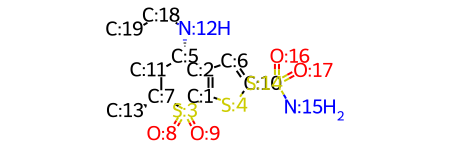

In [195]:
m

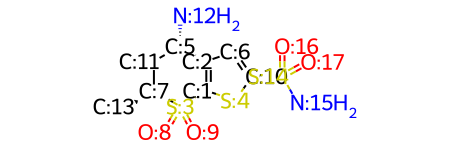

In [196]:
m2

In [197]:
run_reactions(m, m2, reaction_rules)

Cleavage
N-Dealkyaltion
[c:1]12[c:2]([cH:6][c:10]([S:14]([NH2:15])(=[O:16])=[O:17])[s:4]1)[CH:5]([NH:12][CH2:18][CH3:19])[CH2:11][CH:7]([CH3:13])[S:3]2(=[O:8])=[O:9]
[c:1]12[c:2]([cH:6][c:10]([S:14]([NH2:15])(=[O:16])=[O:17])[s:4]1)[CH:5]([NH2:12])[CH2:11][CH:7]([CH3:13])[S:3]2(=[O:8])=[O:9]
[c:1]12[c:2]([cH:6][c:10]([S:14]([NH2:15])(=[O:16])=[O:17])[s:4]1)[CH:5]([NH2:12])[CH2:11][CH:7]([CH3:13])[S:3]2(=[O:8])=[O:9]
 
Cleavage
N-Dealkyaltion
[c:1]12[c:2]([cH:6][c:10]([S:14]([NH2:15])(=[O:16])=[O:17])[s:4]1)[CH:5]([NH:12][CH2:18][CH3:19])[CH2:11][CH:7]([CH3:13])[S:3]2(=[O:8])=[O:9]
[c:1]12[c:2]([cH:6][c:10]([S:14]([NH2:15])(=[O:16])=[O:17])[s:4]1)[CH:5]([NH2:12])[CH2:11][CH:7]([CH3:13])[S:3]2(=[O:8])=[O:9]
[c:1]12[c:2]([cH:6][c:10]([S:14]([NH2:15])(=[O:16])=[O:17])[s:4]1)[CH:5]([NH2:12])[CH2:11][CH:7]([CH3:13])[S:3]2(=[O:8])=[O:9]
 


[12:00:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[12:00:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[12:00:04] Explicit valence for atom # 1 S, 8, is greater than permitted
[12:00:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[12:00:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[12:00:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[12:00:04] Explicit valence for atom # 1 O, 4, is greater than permitted
[12:00:04] Explicit valence for atom # 1 O, 4, is greater than permitted
[12:00:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[12:00:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[12:00:04] Explicit valence for atom # 1 C, 6, is greater than permitted
[12:00:04] Explicit valence for atom # 1 S, 8, is greater than permitted
[12:00:04] Explicit valence for atom # 1 O, 4, is greater than permitted
[12:00:04] Explicit valence for atom # 1 O, 4, is g

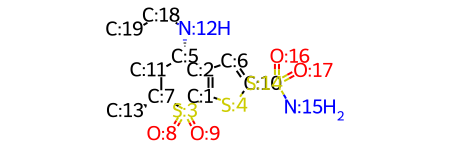

In [198]:
compare_m = m
for atom in compare_m.GetAtoms():
    atom.SetProp('molAtomMapNumber', str(atom.GetIdx()+1))
compare_m